In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def age_model(z1,z2,z3):

    p = [9.80896282e+00,-4.65080541e-03,2.72682487e-02,-3.23531502e+00,2.22256767e-02,4.53706896e-02,
         -8.80208834e-02,-7.28411958e-03,3.80042306e-02,8.48943269e-01,-3.56646067e-02,2.32900165e-02]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [4]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',
                   1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

### GC cluster tables
'''
The ACS survey of Galactic globular clusters – XIV. Bayesian single-population analysis of 69 globular clusters
Wagner-Kaiser et al. 2017
'''
import pandas as pd
supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

supp2 = Table.from_pandas(supp2)
supp3 = Table.from_pandas(supp3)

In [14]:
ngc_names = []
for i in range(len(gcs)):
    
    #47Tuc
    if (gcs['Cluster'][i]=='47Tuc'): 
        ngc_names.append('NGC107')
        
    #M10
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M107
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #M12
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
        
    #M19
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
        
    #M2
    elif (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M22
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M3
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
        
    #M53
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
        
    #M54
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
        
    #M55
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')
        
    #M71
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
    
    #M79
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC6341')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

apogee_clus_idx = []
for i in supp2['Cluster'][s2_ind]:
    apogee_clus_idx.append(np.where(ngc_names==i))


In [16]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

In [34]:
distances = np.ones(len(gcs))
distances_err = np.ones(len(gcs))
for i in range(len(apogee_clus_idx)):
    clus_dist = 10**((supp2['Dist'][i]+5.-supp2['Av'][i])/5.)/1000
    clus_dist_err = 0.461*clus_dist*np.sqrt((supp2['Dist_Sigma'][i])**2+(supp2['Av_Sigma'][i])**2)
    distances[apogee_clus_idx[i]] = clus_dist
    distances_err[apogee_clus_idx[i]] = clus_dist_err

(array([930., 148., 321., 267., 207., 158., 134.,   0.,   0.,  20.]),
 array([ 1.        ,  3.75759054,  6.51518109,  9.27277163, 12.03036217,
        14.78795272, 17.54554326, 20.3031338 , 23.06072435, 25.81831489,
        28.57590543]),
 <a list of 10 Patch objects>)

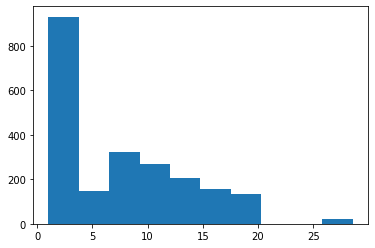

In [36]:
plt.hist(distances)

In [55]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = distances[i]
    dist_err = distances_err[i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        if np.isfinite(absK_new)==True:
            new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
    
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

(array([499.,  87.,  68.,  32.,  21.,  11.,  11.,  16.,  11.,   5.,  13.,
          6.,   5.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 13 Patch objects>)

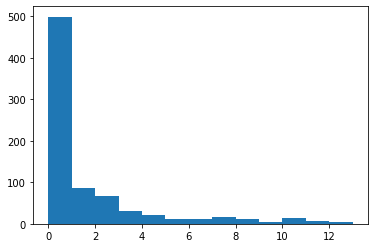

In [56]:
plt.hist(10**(np.asarray(parages)[np.where(gcs['AL_FE']<0.4)])/10**9,range(0,14))

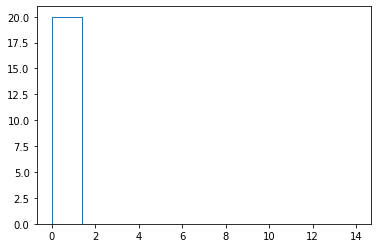

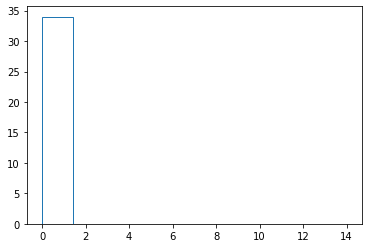

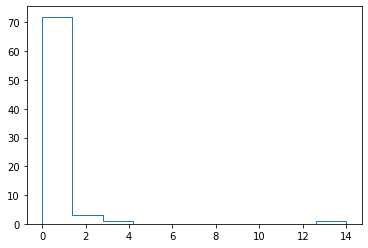

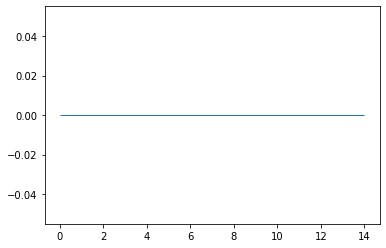

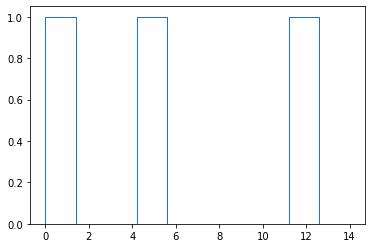

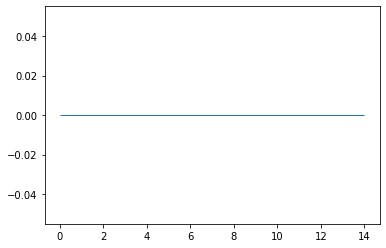

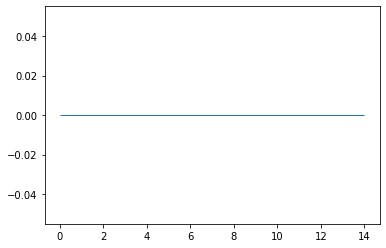

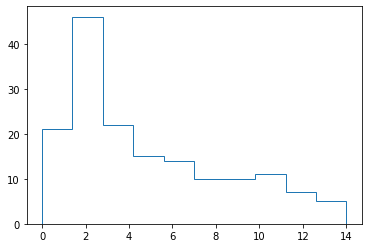

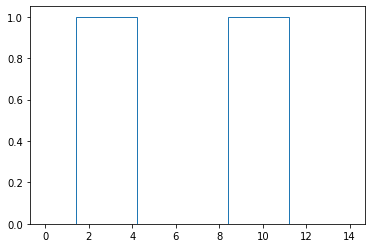

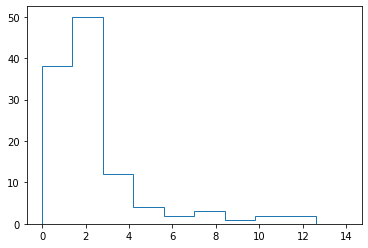

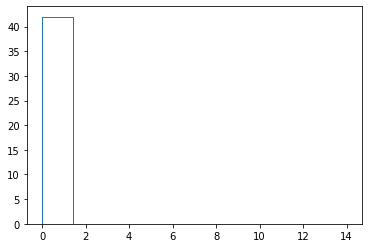

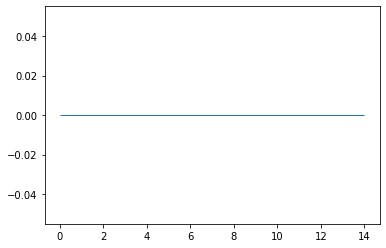

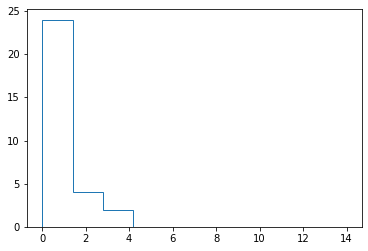

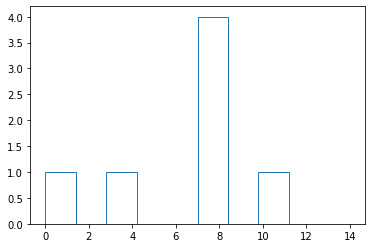

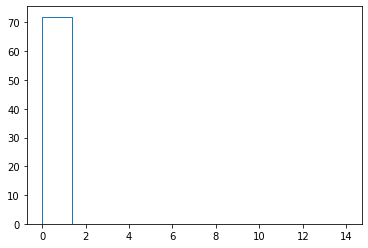

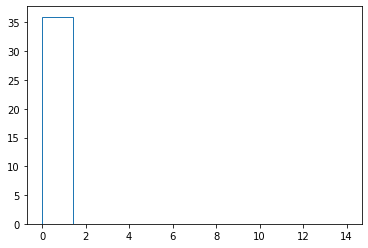

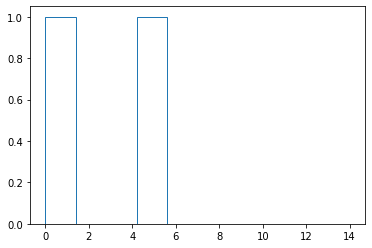

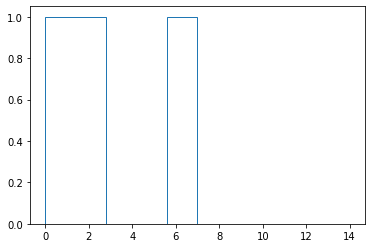

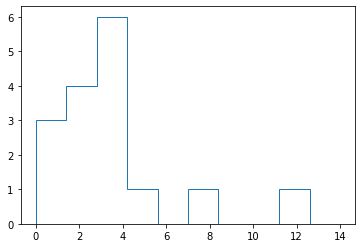

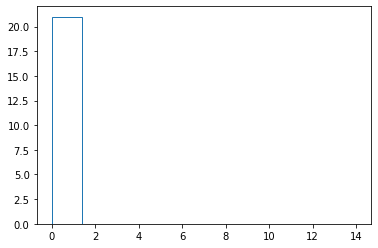

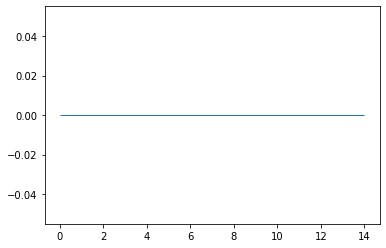

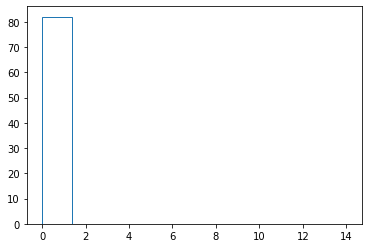

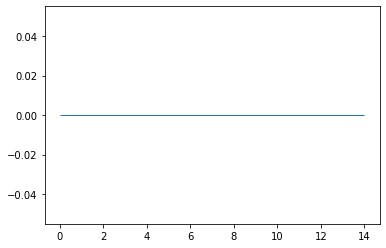

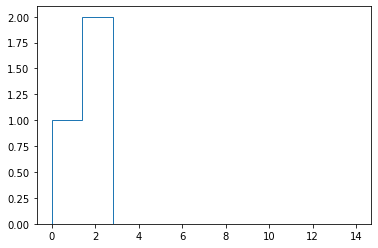

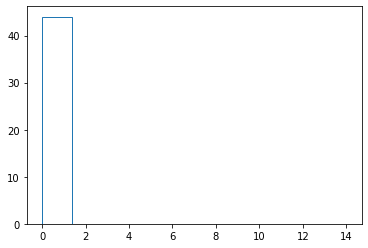

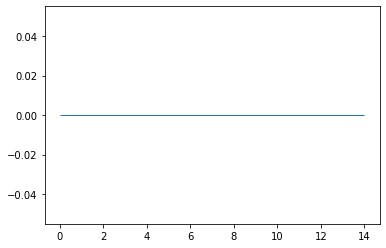

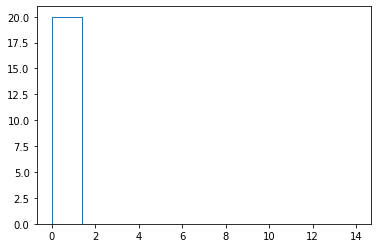

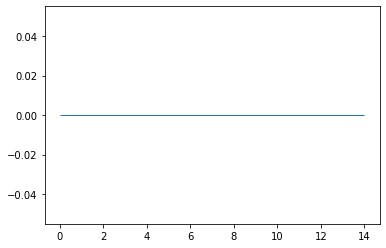

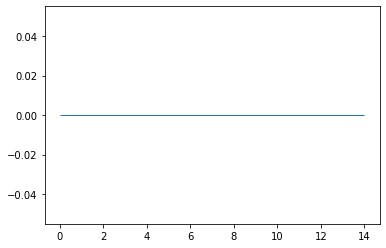

In [57]:
for i in range(len(apogee_clus_idx)):
    plt.figure()
    derived_ages = 10**parages[apogee_clus_idx[i]][np.where(gcs['AL_FE'][apogee_clus_idx[i]]<0.4)]/10**9
    plt.hist(derived_ages,histtype='step',range=(0,14))
    
#     plt.title(r'{}'.format(supp2['Cluster'][s2_ind][apogee_clus_idx[i]]))
    plt.show()